Note this script I ran on a google colab server for pre setup of CUDA environment.

Process smilar to Deepcell-MESMER github notebook.

Output of this code is single cell masks (only on host regions) in tiff format

In [1]:
!pip install deepcell

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 KB 1.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.0/498.0 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 KB 16.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install scikit-image==0.19.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2" # specify visible gpu(s) 0-3

In [4]:
import tensorflow as tf

try:
    tf_gpus = tf.config.list_physical_devices('GPU')
    for gpu in tf_gpus:
        tf.config.experimental.set_memory_growth(gpu, True) # allow memory growth on visible gpu(s)
except:
    pass 

In [5]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import glob
import skimage.io as io
from skimage import img_as_ubyte
from tqdm import tqdm

from deepcell.applications import Mesmer
from deepcell.utils.plot_utils import create_rgb_image, make_outline_overlay

In [12]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [24]:
# paths
base_path = "/content/drive/MyDrive/microMIBI/final_data/masked/2023-02-28T12-53-51-DSST1-Run1/"
output_path = "/content/drive/MyDrive/microMIBI/final_data/masked/2023-02-28T12-53-51-DSST1-Run1/" 
tile_paths = os.listdir(base_path)

try:
    tile_paths.remove(".ipynb_checkpoints")
except:
    pass

In [25]:
# segmentation markers
nuclear_markers = ["dsDNA_host"]
membrane_markers = ["CD45",
                    "Tubulin",
                    "Ecad"]

In [26]:
# need to elegantly remove .shit files here lol
tile_paths.remove('.DS_Store')
tile_paths

['fov-4-scan-1',
 'fov-8-scan-1',
 'fov-9-scan-1',
 'fov-2-scan-1',
 'fov-5-scan-1',
 'fov-3-scan-1',
 'fov-7-scan-1',
 'fov-6-scan-1',
 'fov-1-scan-1',
 'fov-10-scan-1']

In [27]:
for tile_path in tile_paths:
    print("Working on ", tile_path)
    # pull example tiff for image dimensions
    ex_tile_path = os.listdir(os.path.join(base_path, tile_path))[0]
    ex_tile = io.imread(os.path.join(base_path, tile_path, ex_tile_path))
    img_height = ex_tile.shape[0]
    img_width = ex_tile.shape[1]
    
    # glob together markers for this tile
    all_marker_paths = glob.glob(base_path + tile_path + "/*.tiff")
    
    # initialize empty nuclear and membrane arrays
    nuclear_array = membrane_array = np.zeros((img_height, img_width))
    
    # add seg markers to nuclear and membrane arrays
    for marker_path in all_marker_paths:
        marker = marker_path.rsplit("/")[-1].rsplit(".t")[0]
        if marker in nuclear_markers:
            arr = io.imread(marker_path)
            nuclear_array = np.add(nuclear_array, arr)
        elif marker in membrane_markers:
            arr = io.imread(marker_path)
            membrane_array = np.add(membrane_array, arr)
    
    # stack nuclear and membrane together
    stack = np.stack((nuclear_array, membrane_array), axis = -1)
    stack = np.expand_dims(stack, 0) # expand to 4D
    
    # run MESMER
    mesmer = Mesmer()
    
    # maxima_threshold controls what is considered a unique cell (lower values = more separate cells, higher values = fewer cells)
    # interior_threshold determines what is considered background/not part of a cell (lower value = larger cells)
    # default_kwargs_cell = {
    #             'maxima_threshold': 0.075,
    #             'maxima_smooth': 0,
    #             'interior_threshold': 0.2,
    #             'interior_smooth': 2,
    #             'small_objects_threshold': 15,
    #             'fill_holes_threshold': 15,
    #             'radius': 2
    #         }
    
    imageMpp = 0.3 #image_mpp orig 0.25 yh suggest increase
    maximaThreshold = 0.065 #maxima_threshold, orig 0.075
    #interiorThreshold = 0.2 #interior_threshold
    
    for interiorThreshold in [0.05]: # orig 0.01 yh suggest grow little
        print("Working on ", str(imageMpp))
        predictions = mesmer.predict(stack, image_mpp = imageMpp,
                                  postprocess_kwargs_whole_cell={"maxima_threshold" : maximaThreshold,
                                                                 "interior_threshold" : interiorThreshold})

        rgb_image = create_rgb_image(stack, channel_colors = ["green", "blue"])
        overlay = make_outline_overlay(rgb_data = rgb_image, predictions = predictions)

        # save all MESMER outputs
        output_dir = output_path+tile_path+"/"+str(imageMpp)+"mpp_"+str(maximaThreshold)+"maxima_"+str(interiorThreshold)+"interior/"
        if os.path.exists(output_dir) == False:
            os.makedirs(output_dir)

        #io.imsave(output_dir + "nuclear.tiff", nuclear_array, check_contrast = False) # nuclear array 
        #io.imsave(output_dir + "membrane.tiff", membrane_array, check_contrast = False) # membrane array
        io.imsave(output_dir + "seg_outline.tiff", overlay[0, ..., 0], check_contrast = False) # segmentation outline
        io.imsave(output_dir + "seg_overlay.tiff", overlay[0, ...], check_contrast = False) # segmentation overlay (nuc + membrane + outline)
        io.imsave(output_dir + "MESMER_mask.tiff", predictions[0, ..., 0], check_contrast = False) # MESMER mask

Working on  fov-4-scan-1


Working on  0.3
Working on  fov-8-scan-1


Working on  0.3
Working on  fov-9-scan-1


Working on  0.3
Working on  fov-2-scan-1


Working on  0.3
Working on  fov-5-scan-1


Working on  0.3
Working on  fov-3-scan-1


Working on  0.3
Working on  fov-7-scan-1


Working on  0.3
Working on  fov-6-scan-1


Working on  0.3
Working on  fov-1-scan-1


Working on  0.3
Working on  fov-10-scan-1


Working on  0.3


Final suggested segmentation parameter: 

imageMpp = 0.3

maximaThreshold = 0.065

interiorThreshold = 0.05 

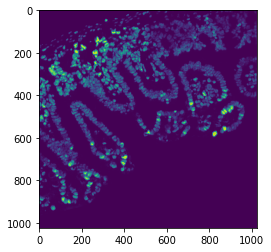

In [30]:
import matplotlib.pyplot as plt
plt.imshow(stack[0,:,:,0])

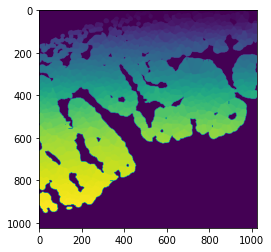

In [31]:
plt.imshow(predictions[0,:,:,0])